In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import haversine
import pygmt
from xarray import DataArray
from scipy.linalg import sqrtm

# Some earth constants
RATE: float = 7.2921159e-5
# Earth's equitorial radius in meters
EQUATORIAL_RADIUS: float = 6378137.0 # meters
# Earth's polar radius in meters
POLAR_RADIUS: float = 6356752.31425 # meters
# Earth's mean radius in meters
MEAN_RADIUS: float = 6371000.0 # meters
# Earth's eccentricity ($e$)
ECCENTRICITY: float = 0.0818191908425 # unit-less
# Earth's eccentricity squared ($e^2$)
ECCENTRICITY_SQUARED: float = ECCENTRICITY * ECCENTRICITY
# Earth's gravitational acceleration at the equator ($g_e$) in $m/s^2$
GE: float = 9.7803253359 # m/s^2, equatorial radius
# Earth's gravitational acceleration at the poles ($g_p$) in $m/s^2$
GP: float = 9.8321849378 # $m/s^2$, polar radius
# Earth's flattening factor ($f$)
F: float = 1.0 / 298.257223563 # Flattening factor
# Somigliana's constant ($K$)
K: float = (POLAR_RADIUS * GP - EQUATORIAL_RADIUS * GE) / (EQUATORIAL_RADIUS * GE) # Somigliana's constant
# Mean radius of the Earth ($R_m$) in meters
RM: float = 6371000.0 # meters, mean radius of the Earth

In [27]:
def gravity(latitude: float, altitude: float) -> float:
    """
    Calculate the normal gravity at a given latitude and altitude.
    
    Parameters:
    - latitude: Latitude in degrees.
    - altitude: Altitude in meters.
    
    Returns:
    - Normal gravity in m/s^2.
    """
    lat_rad = np.radians(latitude)
    sin_lat = np.sin(lat_rad)
    
    # Calculate the normal gravity using the formula
    g = GE * (1 + K * sin_lat**2) / np.sqrt(1 - ECCENTRICITY_SQUARED * sin_lat**2)
    g -= 3.08e-6 * altitude  # Adjust for altitude
    return g

def eotvos(latitude: float, altitude: float, north_velocity: float, east_velocity: float) -> float:
    """
    Calculate the Eötvös correction at a given latitude and altitude.
    
    Parameters:
    - latitude: Latitude in degrees.
    - altitude: Altitude in meters.
    
    Returns:
    - Eötvös correction in mGal.
    """
    lat_rad = np.radians(latitude)
    sin_lat = np.sin(lat_rad)
    
    # Calculate the Eötvös correction using the formula
    return 2 * RATE * east_velocity * np.cos(lat_rad) + (north_velocity**2 + east_velocity**2) / MEAN_RADIUS

In [28]:
data = pd.read_csv('core/data/test_data2.csv', index_col=0, parse_dates=True)
closed = pd.read_csv('core/closed_loop.csv', index_col=0, parse_dates=True)

In [29]:
closed[["acc_bias_x", "acc_bias_y", "acc_bias_z"]]

,acc_bias_x,acc_bias_y,acc_bias_z
timestamp,,,
2025-03-01 16:46:41+00:00,0.001,0.001,0.001
2025-03-01 16:46:42+00:00,0.001,0.001,0.001
2025-03-01 16:46:43+00:00,0.001,0.001,0.001
2025-03-01 16:46:44+00:00,0.001,0.001,0.001
2025-03-01 16:46:45+00:00,0.001,0.001,0.001
...,...,...,...
2025-03-01 18:16:02+00:00,0.001,0.001,0.001
2025-03-01 18:16:03+00:00,0.001,0.001,0.001
2025-03-01 18:16:04+00:00,0.001,0.001,0.001


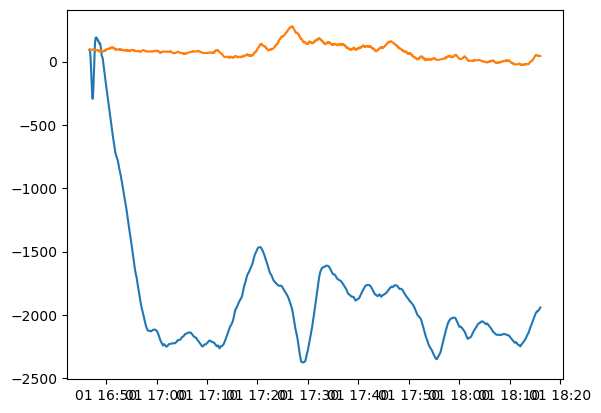

In [42]:
plt.plot(closed.index, closed["altitude"])
plt.plot(data.index, data["altitude"]  )

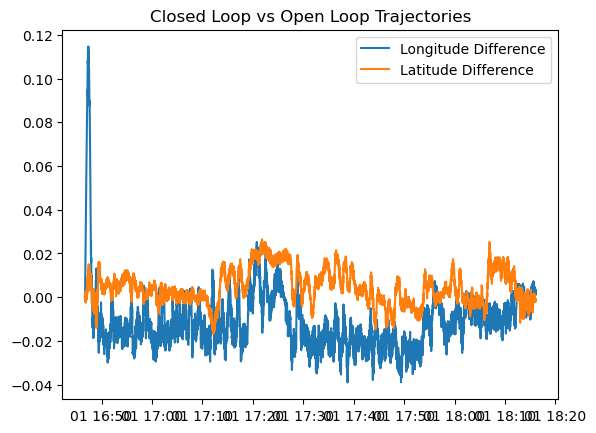

In [46]:
plt.plot(closed.index, (closed['longitude'] - data['longitude']) * 60 * 1852, label='Longitude Difference')
plt.plot(closed.index, (closed['latitude'] - data['latitude']) * 60 * 1852, label='Latitude Difference')

plt.title('Closed Loop vs Open Loop Trajectories')
plt.legend()
plt.show()

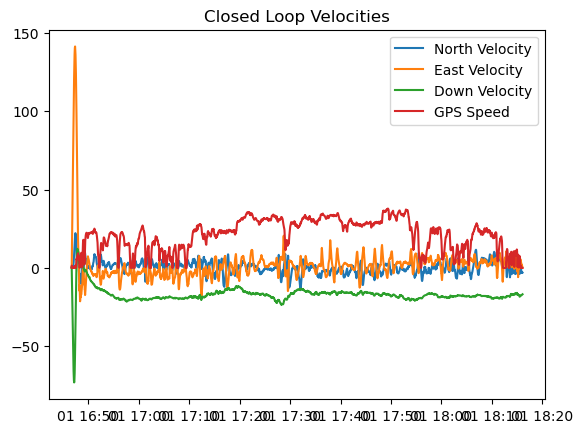

In [52]:
plt.plot(closed.index, closed['velocity_n'], label='North Velocity')
plt.plot(closed.index, closed['velocity_e'], label='East Velocity')
plt.plot(closed.index, closed['velocity_d'], label='Down Velocity')
plt.plot(data.index, data['speed'], label="GPS Speed")
#plt.ylim(-25, 25)
plt.title('Closed Loop Velocities')
plt.legend()
plt.show()

In [53]:
gravity_obs = data[['grav_x', 'grav_y', 'grav_z']].to_numpy()
gravity_obs = np.linalg.norm(gravity_obs, axis=1)
gravity_theoretical = gravity(data['latitude'], data['altitude']).to_numpy()
eotvos_correction = eotvos(closed['latitude'], 
                        closed['altitude'], 
                        closed['velocity_n'], 
                        closed['velocity_e']).to_numpy()
altitude_corretion = 3.08e-6 * closed['altitude'].to_numpy()

In [54]:
altitude_corretion

array([ 0.00028598,  0.00029207,  0.00029525, ..., -0.00598433,
       -0.00598028, -0.00597615], shape=(5366,))

In [55]:
calculated_anomaly = (gravity_obs - gravity_theoretical) * 1e5  # Convert to mGal

In [56]:
calculated_anomaly

array([491.22783221, 491.20242006, 480.72606505, ..., 505.74652899,
       505.06435506, 505.55126112], shape=(5366,))

In [57]:
grav = pygmt.datasets.load_earth_free_air_anomaly(region=[
    data['longitude'].min(), 
    data['longitude'].max(), 
    data['latitude'].min(),
    data['latitude'].max()], resolution='02m')

In [58]:
anomalies = grav.interp(lon=DataArray(data['longitude']),
                        lat=DataArray(data['latitude'])).data

In [59]:
bias = np.mean(calculated_anomaly - anomalies)

In [60]:
bias

np.float64(506.3737998117517)

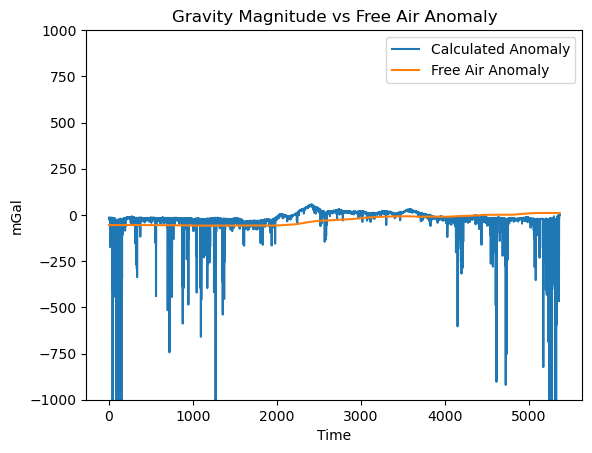

In [61]:
plt.plot(calculated_anomaly - bias, label='Calculated Anomaly')
plt.plot(anomalies, label='Free Air Anomaly')
#plt.plot(eotvos_obs, label='Eötvös Correction', linestyle='--')
plt.xlabel('Time')
plt.ylabel('mGal')
plt.legend()
plt.title('Gravity Magnitude vs Free Air Anomaly')
plt.ylim(-1000, 1000)
plt.show()

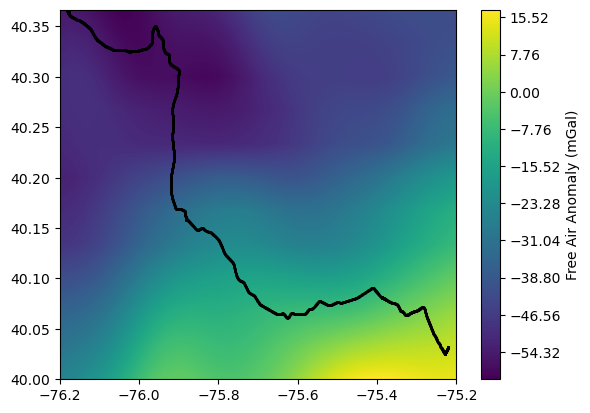

In [40]:
plt.contourf(grav.lon, grav.lat, grav.data, cmap='viridis', levels=1000)
plt.plot(data['longitude'], data['latitude'], 'k.', markersize=1, label='Data Points')
plt.colorbar(label='Free Air Anomaly (mGal)')